### Preamble

In [14]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_probability as tfp
import keras
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm

# import sys
# sys.path.append('./')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 15.0
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['lines.linewidth'] = 2.5

n_hidden = 128
n_samples = 20
max_iter = 30000
batch_size = 16


In [24]:
# https://rmisstastic.netlify.app/how-to/python/generate_html/how%20to%20generate%20missing%20values
import wget
#wget.download('https://raw.githubusercontent.com/BorisMuzellec/MissingDataOT/master/utils.py')

from utils_generation import *
import torch

In [25]:
# Function produce_NA for generating missing values ------------------------------------------------------

def produce_NA(X, p_miss, mecha="MCAR", opt=None, p_obs=0.2, q=None):
    """
    Generate missing values for specifics missing-data mechanism and proportion of missing values. 
    
    Parameters
    ----------
    X : torch.DoubleTensor or np.ndarray, shape (n, d)
        Data for which missing values will be simulated.
        If a numpy array is provided, it will be converted to a pytorch tensor.
    p_miss : float
        Proportion of missing values to generate for variables which will have missing values.
    mecha : str, 
            Indicates the missing-data mechanism to be used. "MCAR" by default, "MAR", "MNAR" or "MNARsmask"
    opt: str, 
         For mecha = "MNAR", it indicates how the missing-data mechanism is generated: using a logistic regression ("logistic"), quantile censorship ("quantile") or logistic regression for generating a self-masked MNAR mechanism ("selfmasked").
    p_obs : float
            If mecha = "MAR", or mecha = "MNAR" with opt = "logistic" or "quanti", proportion of variables with *no* missing values that will be used for the logistic masking model.
    q : float
        If mecha = "MNAR" and opt = "quanti", quantile level at which the cuts should occur.
    
    Returns
    ----------
    A dictionnary containing:
    'X_init': the initial data matrix.
    'X_incomp': the data with the generated missing values.
    'mask': a matrix indexing the generated missing values.s
    """
    
    to_torch = torch.is_tensor(X) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        X = X.astype(np.float32)
        X = torch.from_numpy(X)
    
    if mecha == "MAR":
        mask = MAR_mask(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "logistic":
        mask = MNAR_mask_logistic(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "quantile":
        mask = MNAR_mask_quantiles(X, p_miss, q, 1-p_obs).double()
    elif mecha == "MNAR" and opt == "selfmasked":
        mask = MNAR_self_mask_logistic(X, p_miss).double()
    else:
        mask = (torch.rand(X.shape) < p_miss).double()
    
    X_nas = X.clone()
    X_nas[mask.bool()] = np.nan
    
    return {'X_init': X.double(), 'X_incomp': X_nas.double(), 'mask': mask}

In [31]:
def MNAR_data_process(data):
    N, D = data.shape
    n_latent = D - 1

        # ---- standardize data
    data = data - np.mean(data, axis=0)
    data = data / np.std(data, axis=0)

    # ---- random permutation 
    p = np.random.permutation(N)
    data = data[p, :]

    # ---- we use the full dataset for training here, but you can make a train-val split
    Xtrain = data.copy()
    Xval = Xtrain.copy()

    # ---- introduce missing process
    Xnan = Xtrain.copy()
    Xz = Xtrain.copy()

    # Selecte half of them, if the number is less than mean then we seen them as missing
    # (Using np.nan or 0 to represent)
    mean = np.mean(Xnan[:, :int(D / 2)], axis=0)
    ix_larger_than_mean = Xnan[:, :int(D / 2)] > mean

    Xnan[:, :int(D / 2)][ix_larger_than_mean] = np.nan
    Xz[:, :int(D / 2)][ix_larger_than_mean] = 0

    # Mask to indicate if we have missing value
    S = np.array(~np.isnan(Xnan), dtype=np.float32)

    return N,D,n_latent,p,Xnan,S

In [34]:
def MAR_data_process(data):
    N, D = data.shape
    n_latent = D - 1

        # ---- standardize data
    data = data - np.mean(data, axis=0)
    data = data / np.std(data, axis=0)

    # ---- random permutation 
    p = np.random.permutation(N)
    data = data[p, :]

    X_miss_mcar = produce_NA(data, p_miss=0.4, mecha="MAR")

    X_mcar = X_miss_mcar['X_incomp']
    R_mcar = X_miss_mcar['mask']

    Xnan = X_miss_mcar['X_incomp']
    S = X_miss_mcar['mask']

    return N,D,n_latent,p,Xnan.numpy(),S

### Load data
Here we use the white-wine dataset from the UCI database

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
data1 = np.array(pd.read_csv(url, low_memory=False, sep=';'))
# ---- drop the classification attribute
categorical_data1 = np.round(data1)
numerical_data1 = data1[:, :-1]



In [30]:
N,D,n_latent,p,Xnan,S = MNAR_data_process(numerical_data1)

### Introduce missing 
Here we denote
- Xnan: data matrix with np.nan as the missing entries
- Xz: data matrix with 0 as the missing entries
- S: missing mask 

The missing process depends on the missing data itself:
- in half the features, set the feature value to missing when it is higher than the feature mean

### Build the model
The model we are building has a Gaussian prior and a Gaussian observation model,

$$ p(\mathbf{z}) = \mathcal{N}(\mathbf{z} | \mathbf{0}, \mathbf{I})$$

$$ p(\mathbf{x} | \mathbf{z}) = \mathcal{N}(\mathbf{x} | \mathbf{\mu}_{\theta}(\mathbf{z}), \sigma^2\mathbf{I})$$

$$ p(\mathbf{x}) = \int p(\mathbf{x} | \mathbf{z})p(\mathbf{z}) d\mathbf{z}$$

where $\mathbf{\mu}_{\theta}(\mathbf{z}): \mathbb{R}^d \rightarrow \mathbb{R}^p $ in general is a deep neural net, but in this case is a linear mapping, $\mathbf{\mu} = \mathbf{Wz + b}$.

The variational posterior is also Gaussian

$$q_{\gamma}(\mathbf{z} | \mathbf{x}) = \mathcal{N}(\mathbf{z} | \mu_{\gamma}(\mathbf{x}), \sigma_{\gamma}(\mathbf{x})^2 \mathbf{I})$$

If the missing process is *missing at random*, it is ignorable and the ELBO becomes, as described in [the MIWAE paper](https://arxiv.org/abs/1812.02633)

$$ E_{\mathbf{z}_1...\mathbf{z}_K} \left[ \log \frac{1}{K}\sum_{k=1}^K \frac{p_{\theta}(\mathbf{x^o} | \mathbf{z}_k)p(\mathbf{z}_k)}{q_{\gamma}(\mathbf{z}_k | \mathbf{x^o})} \right] $$

When the missing process is MNAR it is non-ignorable and we need to include the missing model. In this example we include the missing model as a logistic regression in each feature dimension

$$ p_{\phi}(\mathbf{s} | \mathbf{x^o, x^m}) = \text{Bern}(\mathbf{s} | \pi_{\phi}(\mathbf{x^o, x^m}))$$

$$ \pi_{\phi, j}(x_j) = \frac{1}{1 + e^{-\text{logits}_j}} $$

$$ \text{logits}_j = W_j (x_j - b_j) $$

The ELBO in the MNAR case becomes

$$ E_{(\mathbf{z}_1, \mathbf{x}_1^m)...(\mathbf{z}_K, \mathbf{x}_K^m)} \left[ \log \frac{1}{K} \sum_{k=1}^K \frac{p_{\phi}(\mathbf{s} | \mathbf{x}^o, \mathbf{x}_k^m) p_{\theta}(\mathbf{x}^o | \mathbf{z}_k) p(\mathbf{z}_k)}{q_{\gamma}(\mathbf{z} | \mathbf{x}^o)} \right]$$


### Inputs
Let's first define the inputs of the model
- x_pl: data input
- s_pl: mask input
- n_pl: number of importance samples

In [12]:
def imputationRMSE(sess, Xorg, Xnan, L, mu, log_p_x_given_z, log_p_z, log_q_z_given_x,x_pl,s_pl,n_pl):

    N = len(Xorg)
    
    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0
    S = np.array(~np.isnan(Xnan), dtype=np.float32)

    def softmax(x):
        e_x = np.exp(x - np.max(x, axis=1)[:, None])
        return e_x / e_x.sum(axis=1)[:, None]

    def imp(xz, s, L,mu, log_p_x_given_z, log_p_z, log_q_z_given_x,x_pl,s_pl,n_pl):
        _mu, _log_p_x_given_z, _log_p_z, _log_q_z_given_x = sess.run(
            [mu, log_p_x_given_z, log_p_z, log_q_z_given_x],
            {x_pl: xz, s_pl: s, n_pl: L})

        wl = softmax(_log_p_x_given_z + _log_p_z - _log_q_z_given_x)

        xm = np.sum((_mu.T * wl.T).T, axis=1)
        xmix = xz + xm * (1 - s)

        return _mu, wl, xm, xmix

    XM = np.zeros_like(Xorg)

    for i in tqdm(range(N)):

        xz = Xz[i, :][None, :]
        s = S[i, :][None, :]

        _mu, wl, xm, xmix = imp(xz, s, L,mu, log_p_x_given_z, log_p_z, log_q_z_given_x,x_pl,s_pl,n_pl)

        XM[i, :] = xm

        # if i % 100 == 0:
        #     print('{0} / {1}'.format(i, N))

    return np.sqrt(np.sum((Xorg - XM) ** 2 * (1 - S)) / np.sum(1 - S)), XM


def not_imputationRMSE(sess, Xorg, Xnan, L,mu, log_p_x_given_z, log_p_z, log_q_z_given_x, log_p_s_given_x,x_pl,s_pl,n_pl):

    N = len(Xorg)
    
    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0
    S = np.array(~np.isnan(Xnan), dtype=np.float32)

    def softmax(x):
        e_x = np.exp(x - np.max(x, axis=1)[:, None])
        return e_x / e_x.sum(axis=1)[:, None]

    def imp(xz, s, L,mu, log_p_x_given_z, log_p_z, log_q_z_given_x, log_p_s_given_x,x_pl,s_pl,n_pl):                                      # new item
        _mu, _log_p_x_given_z, _log_p_z, _log_q_z_given_x, _log_p_s_given_x  = sess.run(
            [mu, log_p_x_given_z, log_p_z, log_q_z_given_x, log_p_s_given_x],
            {x_pl: xz, s_pl: s, n_pl: L})
                                         # new item
        wl = softmax(_log_p_x_given_z + _log_p_s_given_x + _log_p_z - _log_q_z_given_x)

        xm = np.sum((_mu.T * wl.T).T, axis=1)
        xmix = xz + xm * (1 - s)

        return _mu, wl, xm, xmix

    XM = np.zeros_like(Xorg)

    for i in tqdm(range(N)):

        xz = Xz[i, :][None, :]
        s = S[i, :][None, :]

        _mu, wl, xm, xmix = imp(xz, s, L,mu, log_p_x_given_z, log_p_z, log_q_z_given_x, log_p_s_given_x,x_pl,s_pl,n_pl)

        XM[i, :] = xm

        # if i % 100 == 0:
        #     print('{0} / {1}'.format(i, N))

    return np.sqrt(np.sum((Xorg - XM) ** 2 * (1 - S)) / np.sum(1 - S)), XM

In [16]:
def model(N,D,S,Xz,Xnan, type = "non-MIWAE"):
    print("Creating graph...")
    tf.reset_default_graph()
    # ---- input
    with tf.variable_scope('input'):
        x_pl = tf.placeholder(tf.float32, [None, D], 'x_pl')
        s_pl = tf.placeholder(tf.float32, [None, D], 's_pl')
        n_pl = tf.placeholder(tf.int32, shape=(), name='n_pl')
    # ---- parameters
    with tf.variable_scope('data_process'):
        logstd = tf.get_variable('logstd', shape=[])


    # encoder
    x = keras.layers.Dense(units=n_hidden, activation=tf.nn.tanh, name='l_enc1')(x_pl)
    x = keras.layers.Dense(units=n_hidden, activation=tf.nn.tanh, name='l_enc2')(x)

    q_mu = keras.layers.Dense(units=n_latent, activation=None, name='q_mu')(x)

    q_logstd = keras.layers.Dense(units=n_latent, activation=lambda x: tf.clip_by_value(x, -10, 10),
                            name='q_logstd')(x)


    q_z = tfp.distributions.Normal(loc=q_mu, scale=tf.exp(q_logstd))

    # ---- sample the latent value
    l_z = q_z.sample(n_pl)                    # shape [n_samples, batch_size, dl]
    l_z = tf.transpose(l_z, perm=[1, 0, 2])   # shape [batch_size, n_samples, dl]

    # decoder
    mu = keras.layers.Dense(units=D, activation=None, name='mu')(l_z)

    # likelihood

    p_x_given_z = tfp.distributions.Normal(loc=mu, scale=tf.exp(logstd))

    l_out_mixed = mu * tf.expand_dims(1 - s_pl, axis=1) + tf.expand_dims(x_pl * s_pl, axis=1)



    W = tf.get_variable('W', shape=[1, 1, D])
    W = -tf.nn.softplus(W)
    b = tf.get_variable('b', shape=[1, 1, D])

    logits = W * (l_out_mixed - b)

    p_s_given_x = tfp.distributions.Bernoulli(logits=logits)



    # ---- evaluate the observed data in p(x|z)
    log_p_x_given_z = tf.reduce_sum(tf.expand_dims(s_pl, axis=1) * 
                                    p_x_given_z.log_prob(tf.expand_dims(x_pl, axis=1)), axis=-1)  # sum over d-dimension

    # --- evaluate the z-samples in q(z|x)
    q_z2 = tfp.distributions.Normal(loc=tf.expand_dims(q_z.loc, axis=1), scale=tf.expand_dims(q_z.scale, axis=1))
    log_q_z_given_x = tf.reduce_sum(q_z2.log_prob(l_z), axis=-1)

    # ---- evaluate the z-samples in the prior p(z)
    prior = tfp.distributions.Normal(loc=0.0, scale=1.0)
    log_p_z = tf.reduce_sum(prior.log_prob(l_z), axis=-1)

    # ---- evaluate the mask in p(s|x)
    log_p_s_given_x = tf.reduce_sum(p_s_given_x.log_prob(tf.expand_dims(s_pl, axis=1)), axis=-1)





    lpxz = log_p_x_given_z
    lpz = log_p_z
    lqzx = log_q_z_given_x
    # the additional term for MNAR
    lpsx = log_p_s_given_x

    # ---- MIWAE
    # ---- importance weights
    l_w = lpxz + lpz - lqzx

    # ---- sum over samples
    log_sum_w = tf.reduce_logsumexp(l_w, axis=1)

    # ---- average over samples
    log_avg_weight = log_sum_w - tf.log(tf.cast(n_pl, tf.float32))

    # ---- average over minibatch to get the average llh
    MIWAE = tf.reduce_mean(log_avg_weight, axis=-1)


    # ---- not-MIWAE
    # ---- importance weights
    l_w = lpxz + lpsx + lpz - lqzx

    # ---- sum over samples
    log_sum_w = tf.reduce_logsumexp(l_w, axis=1)

    # ---- average over samples
    log_avg_weight = log_sum_w - tf.log(tf.cast(n_pl, tf.float32))

    # ---- average over minibatch to get the average llh
    notMIWAE = tf.reduce_mean(log_avg_weight, axis=-1)



    # ---- training stuff
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    global_step = tf.Variable(initial_value=0, trainable=False)
    optimizer = tf.train.AdamOptimizer()

    if type == "notMIWAE":

        loss = -notMIWAE
    else:
        loss = -MIWAE

    tvars = tf.trainable_variables()
    train_op = optimizer.minimize(loss, global_step=global_step, var_list=tvars)
    sess.run(tf.global_variables_initializer())



    batch_pointer = 0

    start = time.time()
    best = float("inf")


    for i in tqdm(range(max_iter)):
        x_batch = Xz[batch_pointer: batch_pointer + batch_size, :]
        s_batch = S[batch_pointer: batch_pointer + batch_size, :]

        _, _loss, _step = sess.run([train_op, loss, global_step], {x_pl: x_batch, s_pl: s_batch, n_pl: n_samples})

        batch_pointer += batch_size
        
        if batch_pointer > N - batch_size:
            batch_pointer = 0

            p = np.random.permutation(N)
            Xz = Xz[p, :]
            S = S[p, :]
        
        if i % 100 == 0:
            took = time.time() - start
            start = time.time()
            
            # --- change the following batch if you want a true validation set
            x_batch = Xz  
            s_batch = S
            
            val_loss, _step = sess.run([loss, global_step], {x_pl: x_batch, s_pl: s_batch, n_pl: n_samples})

            #print("{0}/{1} updates, {2:.2f} s, {3:.2f} train_loss, {4:.2f} val_loss".format(i, max_iter, took, _loss, val_loss))


    # ---- S has been permuted during training, so just reinstantiate it
    S = np.array(~np.isnan(Xnan), dtype=np.float32)
    
    if type =="non-MIWAE":
        rmse, imputations = not_imputationRMSE(sess, Xtrain, Xnan, 10000,mu, log_p_x_given_z, log_p_z, log_q_z_given_x, log_p_s_given_x,x_pl,s_pl,n_pl)

    else: 
        rmse, imputations = imputationRMSE(sess, Xtrain, Xnan, 10000, mu, log_p_x_given_z, log_p_z, log_q_z_given_x,x_pl,s_pl,n_pl)

    print("imputation RMSE: ", rmse)

    

In [18]:
# Numerical data and MNAR
model(N,D,S,Xz,Xnan, type = "non-MIWAE")

Creating graph...


100%|██████████| 30000/30000 [00:31<00:00, 959.32it/s]


imputation RMSE:  1.5586905532031796


In [17]:
# Numerical data and MNAR
model(N,D,S,Xz,Xnan, type = "MIWAE")

Creating graph...


100%|██████████| 30000/30000 [00:30<00:00, 968.01it/s]


imputation RMSE:  1.5799188086808005


In [36]:
N,D,n_latent,p,Xnan,S = MAR_data_process(numerical_data1)

In [37]:
# Numerical data and MAR
model(N,D,S,Xz,Xnan, type = "non-MIWAE")

Creating graph...


100%|██████████| 30000/30000 [00:32<00:00, 930.64it/s]


imputation RMSE:  1.1287665575390922


In [38]:
# Numerical data and MAR
model(N,D,S,Xz,Xnan, type = "MIWAE")

Creating graph...


100%|██████████| 30000/30000 [00:31<00:00, 943.72it/s]


imputation RMSE:  1.159302440433158


### Compare to missForest and MICE

In [32]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [33]:
estimator = RandomForestRegressor(n_estimators=100)
imp = IterativeImputer(estimator=estimator)
imp.fit(Xnan)
Xrec = imp.transform(Xnan)
rmse_mf = np.sqrt(np.sum((Xtrain - Xrec) ** 2 * (1 - S)) / np.sum(1 - S))

/opt/homebrew/lib/python3.10/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


ValueError: operands could not be broadcast together with shapes (4898,12) (4898,10) 

In [ ]:
print("missForst imputation RMSE: ", rmse_mf)

missForst imputation RMSE:  1.6266977288476672


In [ ]:
imp = IterativeImputer(max_iter=100)
imp.fit(Xnan)
Xrec = imp.transform(Xnan)
RMSE_iter = np.sqrt(np.sum((Xtrain - Xrec) ** 2 * (1 - S)) / np.sum(1 - S))

In [ ]:
print("MICE, imputation RMSE", RMSE_iter)

MICE, imputation RMSE 1.410276372331692


MAR missing data imputation performance:

* Non - MIWAE RMSE: 1.04
* MIWAE RMSE: 1.38
* missForest RMSE: 1.62
* MICE RMSE: 1.41

### Inspect the learned missing model
There is a separate missing process in each feature dimesion, inspect each of them, plot as function of feature value.

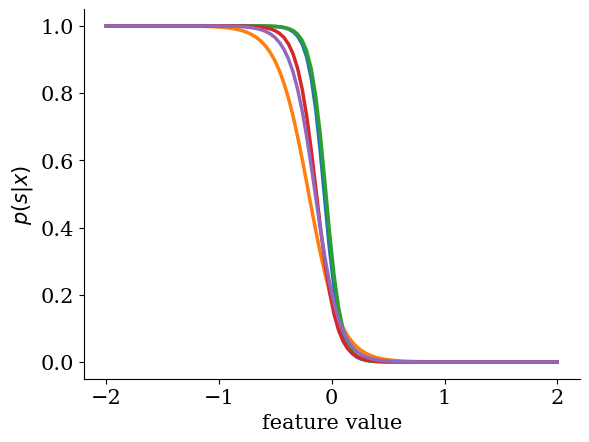

In [48]:
_W, _b = sess.run([W, b])
x = np.linspace(-2, 2, 100)

def sigmoid(logits):
    return 1 / (1 + np.exp(-logits))


plt.figure()

for d in range(D // 2):
    logits = _W[0][0][d] * (x - _b[0][0][d])
    psx = sigmoid(logits)
    plt.plot(x, psx)
    
plt.xlabel('feature value')
plt.ylabel('$p(s|x)$')
plt.show()
plt.close()

This should illustrate that the probability of the feature value being observed when it is below the feature mean should be close to 1, while the probability of being observed above the feature mean should be close to 0.

### Close the session

In [ ]:
# sess.close()